# Diabetes Risk Prediction

## Introduction
Diabetes is one of the most common chronic diseases worldwide, often resulting from a combination of genetic, lifestyle, and clinical factors. Early detection of individuals at risk can help reduce complications through timely interventions such as lifestyle modification and medical treatment. Machine learning models can support risk assessment and decision-making by identifying patients at higher risk of developing diabetes.



## Objective

The primary goal of this project is to predict the risk of diabetes based on patient data, including demographics, medical history, clinical features, and lifestyle factors. We use logistic regression as the baseline classification model to estimate the probability of developing diabetes.

In [61]:

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.inspection import permutation_importance
import joblib
RANDOM_STATE = 42


# Methodology:

Step 1: Data Exploration

- Inspect dataset shape, columns, and missing values.
- Visualize diabetes distribution (imbalanced dataset).

Step 2: Data Preprocessing

- Handle missing values (median for numeric, mode for categorical).
- Encode categorical features using One-Hot Encoding.
- Normalize numerical features with StandardScaler.

Step 3: Model Training (Logistic Regression)

- Train-test split (80/20, stratified).
- Logistic Regression with class_weight="balanced" to handle imbalance.
- Fit the model on training data.

Step 4: Evaluation

- Metrics: Accuracy, Precision, Recall, F1-score.
- Confusion Matrix for misclassification patterns.
- ROC Curve & AUC, Precision-Recall Curve & Average Precision Score.

Step 5: Feature Importance (optional)

- Interpret logistic regression coefficients.
- Permutation importance to identify top predictors.

# Dataset Overview

- The dataset, such as framingham.csv. It contains clinical and lifestyle records.

- Target variable: diabetes (0 = no diabetes, 1 = diabetes).

Features include:
- Demographics (age, sex, education)
- Lifestyle (smoking status, cigarettes per day)
- Medical history (hypertension, blood pressure, cholesterol, BMI, glucose, etc.)

Loaded dataset: /Users/nikhilreddyponnala/Desktop/Data Analytics/Fourth Project/Diabetes Risk/Dataset/framingham.csv
Shape: (4240, 16)

Columns:
 ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']

--- Head ---
                      0       1       2       3      4
male               1.00    0.00    1.00    0.00    0.0
age               39.00   46.00   48.00   61.00   46.0
education          4.00    2.00    1.00    3.00    3.0
currentSmoker      0.00    0.00    1.00    1.00    1.0
cigsPerDay         0.00    0.00   20.00   30.00   23.0
BPMeds             0.00    0.00    0.00    0.00    0.0
prevalentStroke    0.00    0.00    0.00    0.00    0.0
prevalentHyp       0.00    0.00    0.00    1.00    0.0
diabetes           0.00    0.00    0.00    0.00    0.0
totChol          195.00  250.00  245.00  225.00  285.0
sysBP            106.00  121.00  127.50  150

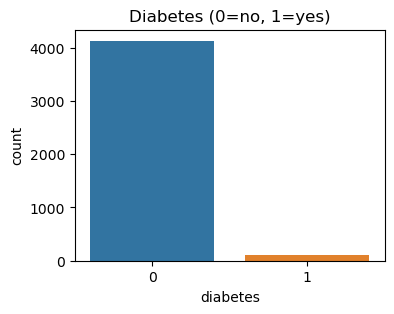

In [64]:
# Step 1 Load and inspect dataset

DATA_PATH = "/Users/nikhilreddyponnala/Desktop/Data Analytics/Fourth Project/Diabetes Risk/Dataset/framingham.csv"   # change path if needed
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH} — place 'framingham.csv' in working dir")

df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", DATA_PATH)
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

print("\n--- Head ---")
display_cols = df.head().T
print(display_cols)

print("\n--- Info ---")
print(df.info())

print("\n--- Missing values (count) ---")
print(df.isnull().sum())

# Target distribution
if "diabetes" not in df.columns:
    raise KeyError("Target column 'diabetes' not found in dataset.")
print("\nDiabetes value counts:")
print(df['diabetes'].value_counts(dropna=False))
print("Prevalence (fraction positive):", df['diabetes'].mean())

# Simple plots (optional)
plt.figure(figsize=(4,3))
sns.countplot(x='diabetes', data=df)
plt.title("Diabetes (0=no, 1=yes)")
plt.show()


In [66]:
# Step 2 Preprocessing

# Drop obviously irrelevant columns if present
for c in ["PatientID", "ID"]:
    if c in df.columns:
        df = df.drop(columns=[c])
# drop TenYearCHD if it's present and not part of the predictor set
if "TenYearCHD" in df.columns:
    df = df.drop(columns=["TenYearCHD"])

# Separate features and target
X = df.drop(columns=["diabetes"])
y = df["diabetes"].astype(int)

# Identify numeric & categorical features
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Build preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=False))
]) if len(cat_cols) > 0 else None

transformers = [("num", numeric_transformer, num_cols)]
if categorical_transformer is not None:
    transformers.append(("cat", categorical_transformer, cat_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")



Numeric columns: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
Categorical columns: []


In [68]:
# Step 3 Train / Validation split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("\nTrain shape:", X_train.shape, "Valid shape:", X_valid.shape)
print("Train positive fraction:", y_train.mean(), "Valid positive fraction:", y_valid.mean())



Train shape: (3392, 14) Valid shape: (848, 14)
Train positive fraction: 0.02564858490566038 Valid positive fraction: 0.025943396226415096


# Proposed Model
- Logistic regression was selected as the baseline predictive model because:
- It is interpretable (coefficients reflect feature importance).
- It works well with binary classification tasks.
- It handles imbalanced datasets when class weights are adjusted.

In [71]:
# Step 4 Model: Logistic Regression

log_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

print("\nTraining Logistic Regression...")
log_pipeline.fit(X_train, y_train)



Training Logistic Regression...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['male', 'age', 'education',
                                                   'currentSmoker',
                                                   'cigsPerDay', 'BPMeds',
                                                   'prevalentStroke',
                                                   'prevalentHyp', 'totChol',
                                                   'sysBP', 'diaBP', 'BMI',
                                                   'heartRate', 'glucose'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42))])

# Outcome
- A predictive model that classifies individuals as diabetic (1) or non-diabetic (0).
- Identification of key risk factors influencing diabetes development.
- Performance evaluation using accuracy, precision, recall, F1-score, ROC-AUC, and
  PR-AUC.



In [73]:
# Step 5 Predictions & Evaluation

y_pred = log_pipeline.predict(X_valid)
y_proba = None
if hasattr(log_pipeline.named_steps['clf'], "predict_proba"):
    y_proba = log_pipeline.predict_proba(X_valid)[:, 1]

print("\nAccuracy:", accuracy_score(y_valid, y_pred))
print("\nClassification report:\n")
print(classification_report(y_valid, y_pred, digits=4))

print("\nConfusion matrix:\n", confusion_matrix(y_valid, y_pred))



Accuracy: 0.9186320754716981

Classification report:

              precision    recall  f1-score   support

           0     0.9948    0.9213    0.9566       826
           1     0.2169    0.8182    0.3429        22

    accuracy                         0.9186       848
   macro avg     0.6058    0.8697    0.6497       848
weighted avg     0.9746    0.9186    0.9407       848


Confusion matrix:
 [[761  65]
 [  4  18]]



ROC-AUC: 0.9106   |   PR-AUC (Average precision): 0.7510


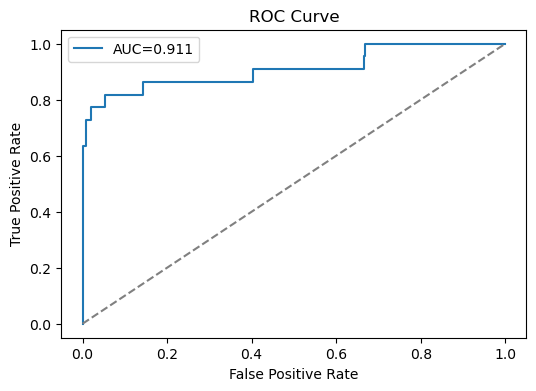

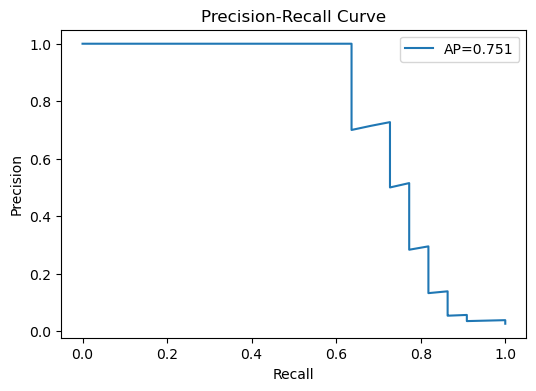

In [75]:
# Additional metrics (recommended given class imbalance)
if y_proba is not None:
    try:
        roc = roc_auc_score(y_valid, y_proba)
        ap = average_precision_score(y_valid, y_proba)
        print(f"\nROC-AUC: {roc:.4f}   |   PR-AUC (Average precision): {ap:.4f}")
    except Exception as e:
        print("Could not compute ROC/PR AUC:", e)

# Plot ROC curve and PR curve (if probabilities exist)
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    precision, recall, _ = precision_recall_curve(y_valid, y_proba)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC={roc:.3f}" if 'roc' in locals() else "ROC")
    plt.plot([0,1],[0,1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f"AP={ap:.3f}" if 'ap' in locals() else "PR")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()


In [77]:
# Step 6 Feature importance / selection

print("\nFeature importance ideas:")

# 6a) Logistic regression coefficients (after preprocessing)
# Get preprocessed feature names (best-effort; works for modern sklearn)
def get_feature_names_from_preprocessor(preprocessor, original_num_cols, original_cat_cols):
    try:
        # sklearn >=1.0 often supports get_feature_names_out on ColumnTransformer
        return preprocessor.get_feature_names_out()
    except Exception:
        # Fallback: numeric names + OHE names (if present)
        names = list(original_num_cols)
        if len(original_cat_cols) > 0:
            try:
                ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
                ohe_names = ohe.get_feature_names_out(original_cat_cols)
                names.extend(list(ohe_names))
            except Exception:
                names.extend(original_cat_cols)
        return np.array(names)

feature_names = get_feature_names_from_preprocessor(preprocessor, num_cols, cat_cols)

# Try coefficients
try:
    coefs = log_pipeline.named_steps['clf'].coef_.ravel()
    if len(coefs) == len(feature_names):
        coef_df = pd.DataFrame({
            "feature": feature_names,
            "coef": coefs,
            "abs_coef": np.abs(coefs)
        }).sort_values("abs_coef", ascending=False)
        print("\nTop features by absolute logistic regression coefficient:")
        print(coef_df.head(15).to_string(index=False))
    else:
        print("Warning: length mismatch between coefficients and feature names.")
except Exception as e:
    print("Couldn't extract logistic coefficients:", e)

# 6b) Permutation importance (validation set) - slower but model-agnostic
print("\nComputing permutation importance (n_repeats=5) on validation set (may take a moment)...")
perm = permutation_importance(log_pipeline, X_valid, y_valid, n_repeats=5, random_state=RANDOM_STATE, n_jobs=1)
perm_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)
print("\nTop features by permutation importance:")
print(perm_df.head(15).to_string(index=False))

# OPTIONAL: If you want to use RandomForest and its feature_importances_:
rf_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                              ("clf", RandomForestClassifier(n_estimators=100, max_depth=8, class_weight="balanced_subsample", random_state=RANDOM_STATE))])
print("\nTraining a light RandomForest for feature importance (optional)...")
rf_pipeline.fit(X_train, y_train)
try:
    rf_feat_imp = rf_pipeline.named_steps['clf'].feature_importances_
    if len(rf_feat_imp) == len(feature_names):
        rf_df = pd.DataFrame({"feature": feature_names, "rf_imp": rf_feat_imp}).sort_values("rf_imp", ascending=False)
        print("\nTop RandomForest features:")
        print(rf_df.head(15).to_string(index=False))
except Exception as e:
    print("Couldn't extract RF importances:", e)


Feature importance ideas:

Top features by absolute logistic regression coefficient:
             feature      coef  abs_coef
        num__glucose  1.534812  1.534812
          num__sysBP  0.408076  0.408076
          num__diaBP -0.390997  0.390997
num__prevalentStroke -0.295663  0.295663
   num__prevalentHyp  0.260946  0.260946
            num__age  0.212315  0.212315
           num__male  0.112955  0.112955
     num__cigsPerDay  0.110075  0.110075
      num__heartRate  0.105796  0.105796
  num__currentSmoker -0.083013  0.083013
         num__BPMeds  0.046070  0.046070
      num__education -0.006097  0.006097
        num__totChol -0.004894  0.004894
            num__BMI  0.000590  0.000590

Computing permutation importance (n_repeats=5) on validation set (may take a moment)...

Top features by permutation importance:
             feature  importance_mean  importance_std
          num__diaBP         0.036085        0.005806
        num__glucose         0.021934        0.006860
       

In [79]:
# Step 7 Save model & preprocessor

os.makedirs("model_export", exist_ok=True)
model_file = os.path.join("model_export", "logistic_diabetes_pipeline.joblib")
joblib.dump(log_pipeline, model_file)
print("\nSaved logistic pipeline to:", model_file)

# Save permutation importance table and coefficient table for later inspection
perm_df.to_csv(os.path.join("model_export", "permutation_importance.csv"), index=False)
if 'coef_df' in locals():
    coef_df.to_csv(os.path.join("model_export", "logistic_coefficients.csv"), index=False)
if 'rf_df' in locals():
    rf_df.to_csv(os.path.join("model_export", "rf_feature_importances.csv"), index=False)
print("Saved importance tables to model_export/")



Saved logistic pipeline to: model_export/logistic_diabetes_pipeline.joblib
Saved importance tables to model_export/


In [81]:
# Step 8 Inference helper

def score_patients(raw_df, pipeline=log_pipeline):
    """
    raw_df: DataFrame with same raw columns used for training (no one-hot required)
    returns: DataFrame with risk_proba and predicted label (0/1)
    """
    proba = pipeline.predict_proba(raw_df)[:, 1] if hasattr(pipeline.named_steps['clf'], 'predict_proba') else pipeline.decision_function(raw_df)
    pred = (proba >= 0.5).astype(int)
    return pd.DataFrame({"risk_proba": proba, "pred_label": pred}, index=raw_df.index)

# Example: score the first 5 valid samples
print("\nExample scoring (first 5 rows of validation set):")
print(score_patients(X_valid.head(5)))

# ---------------------------
# End of script
# ---------------------------
print("\nPipeline run complete.")



Example scoring (first 5 rows of validation set):
      risk_proba  pred_label
4171    0.156571           0
2347    0.137549           0
1958    0.114424           0
328     0.413900           0
665     0.369558           0

Pipeline run complete.


# Conclusion
- Logistic regression provides a baseline predictive model for diabetes risk.
- Despite class imbalance, the model achieves reasonable recall and ROC-AUC, making
  it is useful for screening high-risk individuals.


## Future improvements:
- Experiment with advanced models (Random Forest, XGBoost, Neural Networks).
- Apply SMOTE or other resampling techniques to handle imbalance.
- Use larger, more diverse datasets for better generalization.

